In [ ]:
!pip install -q iso8601
!pip install -q sklearn
!pip install -q seaborn
!pip install -q numba
!pip install -q emd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm

from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

sns.set()
plt.rcParams['figure.figsize'] = [15, 7]

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab_Notebooks')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glassnode import *
from BandPass import BandPass
from smoothers import strided_app,VWAP
from SVR_FN import SVR_predictor,forecast_ols_evaluation,regression_cm

%load_ext google.colab.data_table

**Get price data and denoise**

In [ ]:
GLASSNODE_API_KEY = '1vUcyF35hTk9awbNGszF0KcLuYH'

self = GlassnodeClient()
self.set_api_key(GLASSNODE_API_KEY)

url = URLS['Market'] + 'price_usd_ohlc'
a ='BTC'
c = 'native'
i='24h'

ohlc = self.get(url,a,i,c)

In [ ]:
price = ohlc['c']
_,denoised_price = np.exp(sm.tsa.filters.hpfilter(np.log(price), 500))
denoised_price = pd.Series(denoised_price,index = price.index)


**Get on chain data and perform ADF test to determine if features has to be differenced**

In [ ]:
selected = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/selectedTable.csv')
selected.index = pd.to_datetime(selected['t'])
del selected['t']
selected = selected.astype('float32')

empties = selected.loc['2014':].isna().groupby(selected.loc['2014':].index.year).sum().iloc[-2:].sum()
nonans = empties.loc[empties == 0].index
selected = selected[nonans]

del selected['px_close']
del selected['px_high']	
del selected['px_low']	
del selected['px_open']

In [ ]:
processed = []

for c in tqdm(selected.columns):
  series = selected[c]
  ser = selected[c].astype('float32').copy()
  
  Nd = str(ser.abs().mean()).split('.')[0]
  Ndigits = len(list(Nd))
  
  if Ndigits >1:
    divisor = eval(str('1e')+str(Ndigits))/10
    ser = ser/divisor
    
  adf = adfuller(ser, maxlag=5, regression='ct')

  if adf[1] >= 0.1:
    if ser.min() > 0:
      processed.append(100*np.log(ser).diff().rename(c))
    else:
      processed.append(100*ser.diff().rename(c))
  else:
    processed.append(ser.rename(c))
  
processed = pd.concat(processed,axis = 1)

 69%|██████▊   | 59/86 [00:01<00:00, 48.61it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 86/86 [00:01<00:00, 51.08it/s]


**SVR**

In [ ]:
Target = 100*np.log(denoised_price.shift(-1)/denoised_price).rename('Target')
Pseudo = 100*np.log(price.shift(-1)/price).rename('PTarget')

Xdf = pd.concat([processed['indicators_sopr'],
                 processed['mining_marketcap_thermocap_ratio'],
                 processed['market_mvrv_z_score'],
                 processed['indicators_nvts'],
                 processed['indicators_realized_profit_loss_ratio'],
                 processed['distribution_exchange_net_position_change'],
                 processed['indicators_rhodl_ratio'],
                 processed['indicators_nvt']],axis = 1).dropna()

df = pd.concat([Target,Xdf],axis = 1).dropna()

In [ ]:
Months = np.unique(df.index.strftime('%Y-%m-%d'))
StridedMonths = strided_app(Months,22,1)

frequency = '%Y-%m-%d'
Target = ['Target']

Features = ['indicators_sopr',
            'mining_marketcap_thermocap_ratio',
            'market_mvrv_z_score','indicators_nvts',
            'indicators_realized_profit_loss_ratio',
            'distribution_exchange_net_position_change',
            'indicators_rhodl_ratio',
            'indicators_nvt']

kernel = 'linear'

Y = []
Prc = []

for i in tqdm(range(StridedMonths.shape[0])):
  trainPeriod = list(StridedMonths[i][:-1])
  cvPeriod = StridedMonths[i][-1]

  self = SVR_predictor(df,trainPeriod,cvPeriod,frequency,Target,Features,kernel)
  self.train_cv_split() 
  self.fit()
  Y_ = self.predict()
  Y.append(Y_)
  Prc.append({'month':cvPeriod,'prc':regression_cm(Y_)})

Y = pd.concat(Y,axis = 0)

100%|██████████| 3564/3564 [03:07<00:00, 19.05it/s]


In [ ]:
out = forecast_ols_evaluation(Y['Target'],Y['estimated'])
X = sm.add_constant(Y['estimated'])
y = Y['Target']
mod = sm.OLS(y,X).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     9581.
Date:                Sun, 07 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:39:06   Log-Likelihood:                -3185.2
No. Observations:                3564   AIC:                             6374.
Df Residuals:                    3562   BIC:                             6387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0505      0.010      4.986      0.000       0.031       0.070
estimated      0.7926      0.008     97.882      0.000       0.777       0.808
==============================================================================
Omnibus:                      321.845   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2121.751
Skew:                           0.100   Prob(JB):                         0.00
Kurtosis:                       6.775   Cond. No.                         1.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

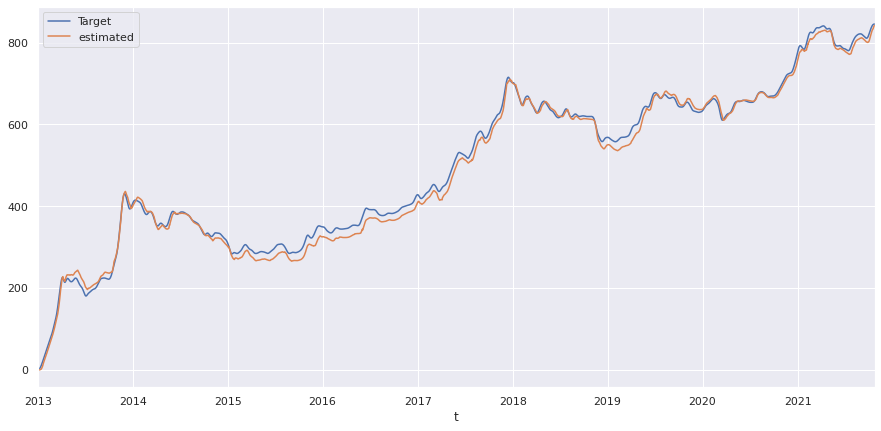

In [ ]:
Y.loc['2013':].cumsum().plot(figsize = (15,7))

In [ ]:
print('pseudo precision:',regression_cm(Y))

pseudo precision: 0.813692480359147


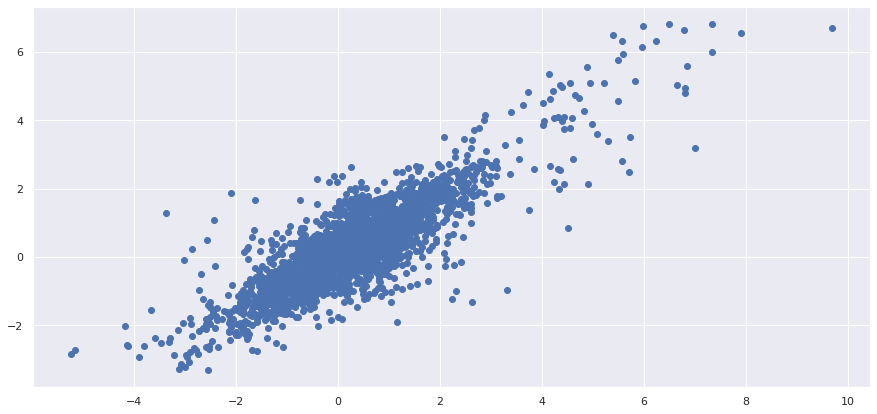

In [ ]:
plt.scatter(Y['estimated'],Y['Target'])

In [ ]:
Z = processed.dropna()

from sklearn.decomposition import PCA

pca = PCA(n_components = 6,svd_solver='full')
pca.fit(Z)

print(pca.explained_variance_ratio_)

principalComponents = pca.fit_transform(Z)
principalDf = pd.DataFrame(data = -principalComponents,index = Z.index)


[0.39336446 0.13950121 0.09959584 0.09451892 0.08835151 0.04032706]


In [ ]:
principalDf.plot()

In [ ]:
YY = pd.concat([Pseudo,Y],axis = 1).dropna()

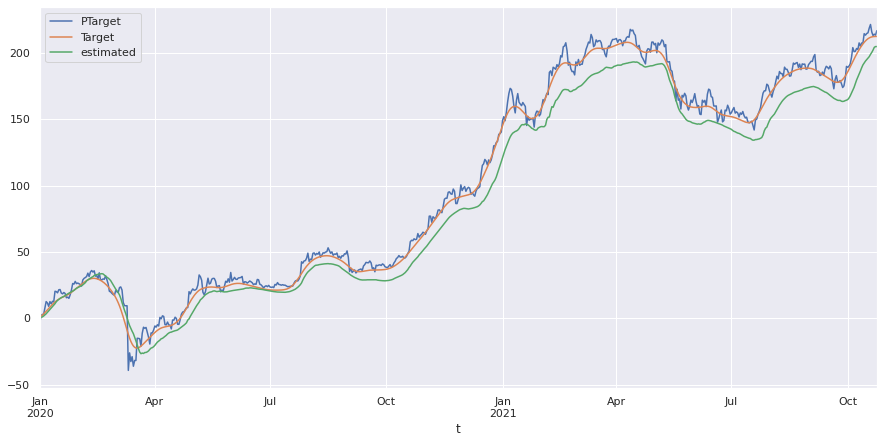

In [ ]:
YY.loc['2020':].cumsum().plot()